# Imports

In [ ]:
import random
import math
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Old slow code for value and policy iteration

In [ ]:
from dataclasses import dataclass

class MDP:
	def __init__(self):
		self.actions = [i for i in range(-5, 6)]
		self.gamma = 0.9
		self.neg_inf = -1000

	@staticmethod
	def transition_probability(s: tuple[int,int], t: tuple[int,int], a: int):
		cap1 = 20
		cap2 = 20
		lambda_rent_1, lambda_rent_2 = 3, 4
		lambda_ret_1, lambda_ret_2 = 3, 2

		m1 = s[0] - a
		m2 = s[1] + a
		e1, e2 = t

		# Bounds checks
		if not (0 <= m1 <= cap1 and 0 <= m2 <= cap2):
			return 0.0
		if not (0 <= e1 <= cap1 and 0 <= e2 <= cap2):
			return 0.0

		def single_location_prob(cars_morning: int, cars_evening: int, capacity: int, lambda_rent: float, lambda_return: float) -> float:
			# Impossible evening count
			if cars_evening < 0 or cars_evening > capacity:
				return 0.0
			total = 0.0
			for cars_rented in range(cars_morning + 1):
				# Rentals probability: exact for < cars_morning, tail for == cars_morning
				if cars_rented < cars_morning:
					prob_rentals = poisson.pmf(cars_rented, lambda_rent)
				else:
					prob_rentals = poisson.sf(cars_rented - 1, lambda_rent)

				cars_after_rentals = cars_morning - cars_rented
				returns_needed = cars_evening - cars_after_rentals
				if returns_needed < 0:
					continue

				# Returns probability: exact for < capacity, tail at saturation
				if cars_evening < capacity:
					prob_returns = poisson.pmf(returns_needed, lambda_return)
				else:
					prob_returns = poisson.sf(returns_needed - 1, lambda_return)

				total += prob_rentals * prob_returns
			return total

		p1 = single_location_prob(m1, e1, cap1, lambda_rent_1, lambda_ret_1)
		p2 = single_location_prob(m2, e2, cap2, lambda_rent_2, lambda_ret_2)
		return p1 * p2

	@staticmethod
	def reward(s: tuple[int,int], t: tuple[int,int], a: int):
		cap1 = 20
		cap2 = 20
		lambda_rent_1, lambda_rent_2 = 3, 4
		movement_cost_per_car = 2
		revenue_per_rental = 10

		m1 = s[0] - a
		m2 = s[1] + a
		# If action leads to invalid morning state, heavily penalize
		if not (0 <= m1 <= cap1 and 0 <= m2 <= cap2):
			return -1000

		def expected_rentals(lambda_param: float, max_cars: int) -> float:
			if lambda_param < 0 or max_cars < 0:
				return 0.0
			# Sum k * P(K=k) for k <= max_cars, plus tail where rentals are capped at max_cars
			sum_k_pk = 0.0
			for k in range(max_cars + 1):
				sum_k_pk += k * poisson.pmf(k, lambda_param)
			return sum_k_pk + max_cars * poisson.sf(max_cars, lambda_param)

		revenue = revenue_per_rental * (expected_rentals(lambda_rent_1, m1) + expected_rentals(lambda_rent_2, m2))
		cost = movement_cost_per_car * abs(a)
		return revenue - cost

	@staticmethod
	def initialize_state_dict(initial_value) -> dict:
		state_dict = dict()
		for i in range(21):
			for j in range(21):
				state_dict[(i,j)] = initial_value
		return state_dict


class Policy:
	def __init__(self, mdp: MDP):
		self.mdp = mdp
		default_action = self.mdp.actions[0]
		self.pi = self.mdp.initialize_state_dict(default_action)

	def __call__(self, state: tuple[int, int]) -> int:
		return self.pi[state]


class ValueFunction:
	def __init__(self, mdp: MDP):
		self.mdp = mdp
		self.v = self.mdp.initialize_state_dict(0.0)

	def __call__(self, state: tuple[int, int]) -> float:
		return self.v[state]

	def compute_q_value(self, state: tuple[int,int], action: int) -> float:
		# this is very inefficient, I should add a function that, given a state,
		# returns all possible next states, then I should iterate over those states
		# Minimal fix: if action leads to invalid morning state, treat it as -inf
		m1 = state[0] - action
		m2 = state[1] + action
		if m1 < 0 or m1 > 20 or m2 < 0 or m2 > 20:
			return self.mdp.neg_inf
		q_value = 0
		for next_state, value in self.v.items():
			q_value += self.mdp.transition_probability(state, next_state, action) * (self.mdp.reward(state, next_state, action) + self.mdp.gamma * value)
		return q_value

	def compute_value_update(self, state: tuple[int,int], action: int | None = None) -> float:
		if action is not None:
			q_value = self.compute_q_value(state, action)
			return q_value
		else:
			max_value = self.mdp.neg_inf
			for action in self.mdp.actions:
				q_value = self.compute_q_value(state, action)
				max_value = max(max_value, q_value)
			return max_value

	def value_iteration(self, theta: float, max_iterations: int = 1000, policy: Policy | None = None) -> int:
		for n in range(max_iterations):
			print(f"---------- Iteration {n} ----------")
			if n == 1:
				break
			next_V = self.mdp.initialize_state_dict(0.0)

			for state in self.v.keys():
				print(state)
				action = None if policy is None else policy(state)
				next_V[state] = self.compute_value_update(state, action)

			max_delta = 0
			for state in self.v.keys():
				delta = abs(self.v[state] - next_V[state])
				max_delta = max(max_delta, delta)

			self.v = next_V

			if max_delta < theta:
				return n+1

		return max_iterations


def run_policy_iteration(mdp, value_function, policy, theta, max_iterations):
	for n in range(max_iterations):
		value_function.value_iteration(theta, max_iterations, policy)
		policy_stable = True

		for state in policy.pi.keys():
			optimal_action = policy.pi[state]
			max_value = mdp.neg_inf
			for action in mdp.actions:
				q_value = value_function.compute_q_value(state, action)
				if q_value > max_value:
					max_value = q_value
					optimal_action = action
			if policy.pi[state] != optimal_action:
				policy_stable = False
			policy.pi[state] = optimal_action

		if policy_stable:
			break

# Code for running value and policy iteration

In [ ]:
class MDP:
	def __init__(self, action_range: tuple[int,int], location_capacity: tuple[int,int], rental_params: tuple[int,int], return_params: tuple[int,int], gamma: float):
		"""
		Initializes the MDP environment for the car rental problem.

		Args:
			action_range: A tuple (min_action, max_action)
				defining the inclusive range of actions. The action is a single integer with the following  convention:
				- A positive action 'a' represents moving 'a' cars from location 1 to 2.
				- A negative action 'a' represents moving '|a|' cars from location 2 to 1.
			location_capacity: The maximum car capacity for each location, e.g., (20, 20).
			rental_params: The average rental requests (λ) for each location.
			return_params: The average car returns (λ) for each location.
			gamma: The discount factor for future rewards.
		"""
		self.action_range = action_range
		self.actions = np.arange(self.action_range[0], self.action_range[1] + 1)
		self.location_capacity = location_capacity
		self.rental_params = rental_params
		self.return_params = return_params
		self.gamma = gamma

		# Transition probability from morning state to evening state
		self.transition_prob_matrix = self.build_transition_prob_matrix()
		#
		self.expected_reward_matrix = self.build_expected_reward_array()

	# 1 ---- Compute transition matrix ----
	@staticmethod
	def compute_single_location_transition_prob(cars_morning: int, cars_evening: int, capacity: int, lambda_rent: float, lambda_return: float) -> float:
		"""
		Calculates the probability of transitioning from cars_morning to cars_evening at a single location.
		"""
		# It's impossible to end with more cars than capacity or a negative number.
		if cars_evening > capacity or cars_evening < 0:
			return 0.0

		total_prob = 0.0

		# Sum probabilities over every possible number of rentals (from 0 to cars_morning).
		for cars_rented in range(cars_morning + 1):
			if cars_rented < cars_morning:
				prob_rentals = poisson.pmf(cars_rented, lambda_rent)
			else: # cars_rented == cars_morning
				prob_rentals = poisson.sf(cars_rented - 1, lambda_rent)

			cars_after_rentals = cars_morning - cars_rented
			returns_needed = cars_evening - cars_after_rentals

			if returns_needed < 0:
				continue

			if cars_evening < capacity:
				prob_returns = poisson.pmf(returns_needed, lambda_return)
			else: # cars_evening == capacity
				prob_returns = poisson.sf(returns_needed - 1, lambda_return)

			total_prob += prob_rentals * prob_returns

		return total_prob

	@staticmethod
	def build_single_location_transition_prob_matrix(capacity: int, lambda_rent: float, lambda_return: float
	) -> np.ndarray:
		"""Builds the (capacity+1, capacity+1) state transition matrix for a single location."""
		# The matrix size is capacity+1 to account for the state of 0 cars.
		num_states = capacity + 1
		transition_matrix = np.zeros((num_states, num_states))

		for morning_state in range(num_states):
			for evening_state in range(num_states):
				prob = MDP.compute_single_location_transition_prob(
					morning_state, evening_state, capacity, lambda_rent, lambda_return
				)
				transition_matrix[morning_state, evening_state] = prob

		return transition_matrix

	def build_transition_prob_matrix(self) -> np.ndarray:
		"""
		Builds the 4D transition probability tensor P[m1, m2, e1, e2].

		This tensor gives the probability of transitioning from a morning state (m1, m2)
		to an evening state (e1, e2).
		"""
		# Build the individual transition matrices for each location.
		p_loc1 = MDP.build_single_location_transition_prob_matrix(
			self.location_capacity[0], self.rental_params[0], self.return_params[0]
		)
		p_loc2 = MDP.build_single_location_transition_prob_matrix(
			self.location_capacity[1], self.rental_params[1], self.return_params[1]
		)

		# Combine the matrices into a 4D tensor using an outer product.
		# P[m1, m2, e1, e2] = p_loc1[m1, e1] * p_loc2[m2, e2]
		transition_tensor = np.einsum('ik,jl->ijkl', p_loc1, p_loc2)

		return transition_tensor

	# 2 ---- Compute reward matrix ----
	@staticmethod
	def build_expected_rentals_array(capacity: int, lambda_param: float) -> np.ndarray:
		"""
		Creates an array for expected rentals.
		"""
		expected_rentals = np.zeros(capacity + 1)

		for available_cars in range(capacity + 1):
			# For a given k, sum the probability-weighted rentals for demands j < k
			current_expected_rentals = 0.0
			for demand in range(available_cars + 1):
				prob = poisson.pmf(demand, lambda_param)
				current_expected_rentals += demand * prob

			# Whenever demand > available_cars, exactly available_cars cars are rented.
			tail_prob = poisson.sf(available_cars, lambda_param)
			current_expected_rentals += available_cars * tail_prob

			expected_rentals[available_cars] = current_expected_rentals

		return expected_rentals

	def build_expected_reward_array(self) -> np.ndarray:
		"""
		Builds the 3D reward array R[action, c1, c2] using pre-computed lookup tables.
		"""
		cap1, cap2 = self.location_capacity
		num_actions = len(self.actions)

		# Pre-compute the expected rentals for all possible car counts at each location.
		expected_rentals_loc1 = MDP.build_expected_rentals_array(cap1, self.rental_params[0])
		expected_rentals_loc2 = MDP.build_expected_rentals_array(cap2, self.rental_params[1])

		reward_array = np.zeros((num_actions, cap1 + 1, cap2 + 1))

		for a_idx, action in enumerate(self.actions):
			for c1 in range(cap1 + 1):
				for c2 in range(cap2 + 1):
					cars_morn_loc1 = c1 - action
					cars_morn_loc2 = c2 + action

					# If the action is invalid, set the reward to -np.inf.
					if not (0 <= cars_morn_loc1 <= cap1 and 0 <= cars_morn_loc2 <= cap2):
						reward_array[a_idx, c1, c2] = -np.inf
					else:
						# Use the fast lookup tables instead of recalculating
						rentals1 = expected_rentals_loc1[cars_morn_loc1]
						rentals2 = expected_rentals_loc2[cars_morn_loc2]

						revenue = 10 * (rentals1 + rentals2)
						cost = 2 * abs(action)
						reward_array[a_idx, c1, c2] = revenue - cost

		return reward_array


class Policy:
	def __init__(self, mdp: MDP):
		self.mdp = mdp
		cap1, cap2 = self.mdp.location_capacity

		default_action = 0
		self.pi = np.full((cap1 + 1, cap2 + 1), default_action, dtype=int)

	def __call__(self, state: tuple[int, int]) -> int:
		# This works just like the dictionary version, thanks to tuple indexing.
		return self.pi[state]


class ValueFunction:
	def __init__(self, mdp: MDP):
		self.mdp = mdp
		cap1, cap2 = self.mdp.location_capacity
		self.v = np.zeros((cap1 + 1, cap2 + 1), dtype=float)

	def __call__(self, state: tuple[int, int]) -> float:
		return self.v[state]

	def build_q_value_array(self) -> np.ndarray:
		"""
		Computes the 3D Q-value array Q[action, c1, c2] for all state-action pairs simultaneously.
		"""
		cap1, cap2 = self.mdp.location_capacity
		num_actions = len(self.mdp.actions)
		q_values = np.zeros((num_actions, cap1 + 1, cap2 + 1))

		# Compute the expected value for every possible MORNING state.
		# Note that P(s'|s,a) = P(s'|m), where m is the morning state.
		# So we can substitute P(s'|s,a) for P(s'|m) in the Q-value equation
		expected_value_from_morning_state = np.einsum(
			'ijkl,kl->ij',
			self.mdp.transition_prob_matrix,
			self.v
		)

		for a_idx, action in enumerate(self.mdp.actions):
			rewards = self.mdp.expected_reward_matrix[a_idx, :, :]
			future_values = np.zeros_like(expected_value_from_morning_state)

			# The action transforms the initial state (c1, c2) into a morning state (c1-action, c2+action).
			# So, given the morning state (m1, m2), we get the initial state (m1+action, m2-action).
			a = abs(action)
			if action > 0: # Moving cars from location 1 to 2
				future_values[a:, :-a] = expected_value_from_morning_state[:-a, a:]
			elif action < 0: # Moving cars from location 2 to 1
				future_values[:-a, a:] = expected_value_from_morning_state[a:, :-a]
			else: # No action
				future_values = expected_value_from_morning_state.copy()

			q_values[a_idx, :, :] = rewards + self.mdp.gamma * future_values

		return q_values

	def value_iteration(self, theta: float, max_iterations: int = 1000, policy: Policy | None = None) -> int:
		"""
		Runs the value iteration algorithm to find the optimal value function. If a policy is provided, it runs policy evaluation instead.
		"""
		for i in range(max_iterations):
			v_old = self.v.copy()
			q_values = self.build_q_value_array()
			if policy is None: # Pick the maximum Q-value for each state
				self.v = np.max(q_values, axis=0)
			else: # Pick the Q-value for the action in the policy
				policy_action_indices = policy.pi + abs(self.mdp.action_range[0])
				# Choose the Q-value for the action in the policy
				self.v = np.choose(policy_action_indices, q_values)

			delta = np.max(np.abs(self.v - v_old))
			if delta < theta:
				return i + 1

		return max_iterations

	def get_optimal_policy(self) -> Policy:
		"""
		Computes the optimal policy from the converged value function.
		"""
		policy = Policy(self.mdp)
		q_values = self.build_q_value_array()
		optimal_action_indices = np.argmax(q_values, axis=0)
		policy.pi = self.mdp.actions[optimal_action_indices]

		return policy


def run_policy_iteration(mdp: MDP, value_function: ValueFunction, policy: Policy, theta: float, max_iterations: int = 1000) -> int:
	for i in range(max_iterations):
		value_function.value_iteration(theta, max_iterations, policy=policy)

		old_policy_pi = policy.pi.copy()
		q_values = value_function.build_q_value_array()
		policy.pi = mdp.actions[np.argmax(q_values, axis=0)]

		if np.array_equal(policy.pi, old_policy_pi):
			return i + 1

	return max_iterations


def plot_integer_array_contour(data_array, title='Integer Array Contour Plot'):
	"""
	Generates and displays a contour plot for a 2D array of integers
	by manually drawing boundary lines. This avoids interpolation artifacts.

	Args:
		data_array (list or np.ndarray): A 2D list or NumPy array of integers.
		title (str): The title for the plot.
	"""
	# Ensure the input is a NumPy array for efficient processing
	data = np.array(data_array)
	if data.ndim != 2:
		raise ValueError("Input must be a 2-dimensional array.")

	rows, cols = data.shape
	fig, ax = plt.subplots(figsize=(8, 8))

	# --- Manually Draw Boundary Lines ---
	# Iterate over each cell to draw the lines on its bottom and right edges
	for r in range(rows):
		for c in range(cols):
			# Check for a change in value below the current cell
			if r < rows - 1 and data[r, c] != data[r + 1, c]:
				ax.plot([c - 0.5, c + 0.5], [r + 0.5, r + 0.5], color='black', linewidth=1.5)
			# Check for a change in value to the right of the current cell
			if c < cols - 1 and data[r, c] != data[r, c + 1]:
				ax.plot([c + 0.5, c + 0.5], [r - 0.5, r + 0.5], color='black', linewidth=1.5)

	# Draw the outer border of the entire grid
	ax.plot([-0.5, cols - 0.5], [-0.5, -0.5], color='black', linewidth=1.5) # Top edge
	ax.plot([-0.5, cols - 0.5], [rows - 0.5, rows - 0.5], color='black', linewidth=1.5) # Bottom edge
	ax.plot([-0.5, -0.5], [-0.5, rows - 0.5], color='black', linewidth=1.5) # Left edge
	ax.plot([cols - 0.5, cols - 0.5], [-0.5, rows - 0.5], color='black', linewidth=1.5) # Right edge

	# --- Add Labels to the Center of Each Contiguous Region ---
	visited = np.zeros_like(data, dtype=bool)
	for r in range(rows):
		for c in range(cols):
			if not visited[r, c]:
				level = data[r, c]
				current_region_coords = []
				q = [(r, c)] # Queue for Breadth-First Search (BFS)
				visited[r, c] = True

				head = 0
				while head < len(q):
					curr_r, curr_c = q[head]
					head += 1
					current_region_coords.append((curr_r, curr_c))

					# Check neighbors (up, down, left, right)
					for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
						nr, nc = curr_r + dr, curr_c + dc

						if (0 <= nr < rows and 0 <= nc < cols and
							not visited[nr, nc] and data[nr, nc] == level):
							visited[nr, nc] = True
							q.append((nr, nc))

				# Now we have a single contiguous region. Find its best label position.
				if current_region_coords:
					region_np = np.array(current_region_coords)
					# Calculate the geometric center (mean) of the region
					center_y, center_x = region_np.mean(axis=0)

					# Find the actual cell in the region closest to this center point
					distances = np.sum((region_np - [center_y, center_x])**2, axis=1)
					closest_idx = np.argmin(distances)
					label_r, label_c = region_np[closest_idx]

					# Add the text label at the center of the chosen cell
					ax.text(label_c, label_r, f'{level}', ha='center', va='center',
							bbox=dict(facecolor='white', edgecolor='none', pad=0.1))

	# --- Plot Styling ---
	ax.set_aspect('equal', 'box')
	ax.set_title(title, fontsize=16)
	ax.set_xlabel('#Cars at second location')
	ax.set_ylabel('#Cars at first location')

	ax.xaxis.set_major_locator(MaxNLocator(integer=True))
	ax.yaxis.set_major_locator(MaxNLocator(integer=True))

	ax.set_xlim(-0.5, cols - 0.5)
	ax.set_ylim(-0.5, rows - 0.5)

	plt.show()



# Experiments

In [ ]:
def display_optimal_policy_value_iteration(mdp: MDP, theta: float=0.01, max_iterations: int=1000):
    value_function = ValueFunction(mdp)
    n_iterations = value_function.value_iteration(theta=theta, max_iterations=max_iterations)
    print(f"Number of iterations until convergence: {n_iterations}")
    policy = value_function.get_optimal_policy()
    plot_integer_array_contour(policy.pi, f"Value Iteration, gamma = {mdp.gamma}")

def display_optimal_policy_policy_iteration(mdp: MDP, theta: float=0.01, max_iterations: int=1000):
    value_function = ValueFunction(mdp)
    policy = Policy(mdp)
    n_iterations = run_policy_iteration(mdp, value_function, policy, theta=theta, max_iterations=max_iterations)
    print(f"Number of iterations until convergence: {n_iterations}")
    policy = value_function.get_optimal_policy()
    plot_integer_array_contour(policy.pi, f"Policy Iteration, gamma = {mdp.gamma}")

## Experiment with gamma = 0.9

In [ ]:
gamma = 0.9

In [ ]:
mdp = MDP(
	action_range=(-5, 5),
	location_capacity=(20, 20),
	rental_params=(3, 4),
	return_params=(3, 2),
	gamma=gamma
)

Number of iterations until convergence: 82


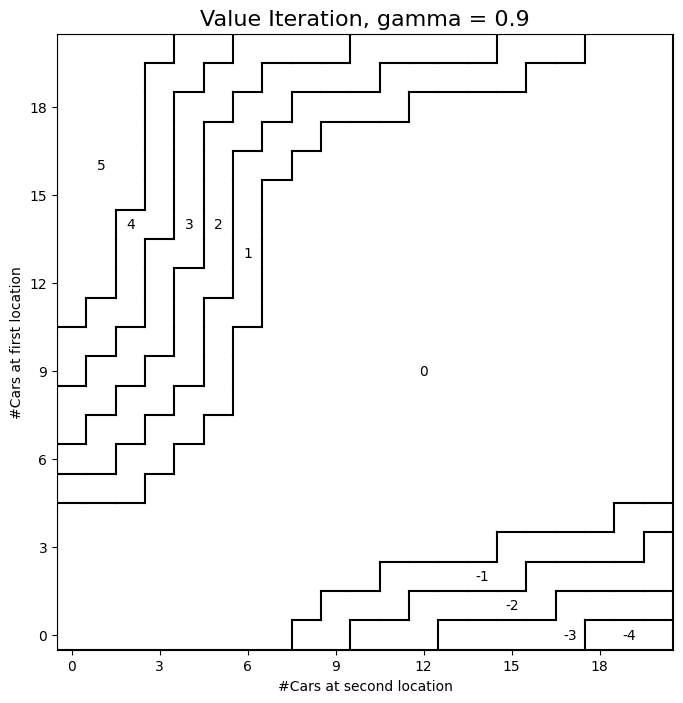

Number of iterations until convergence: 5


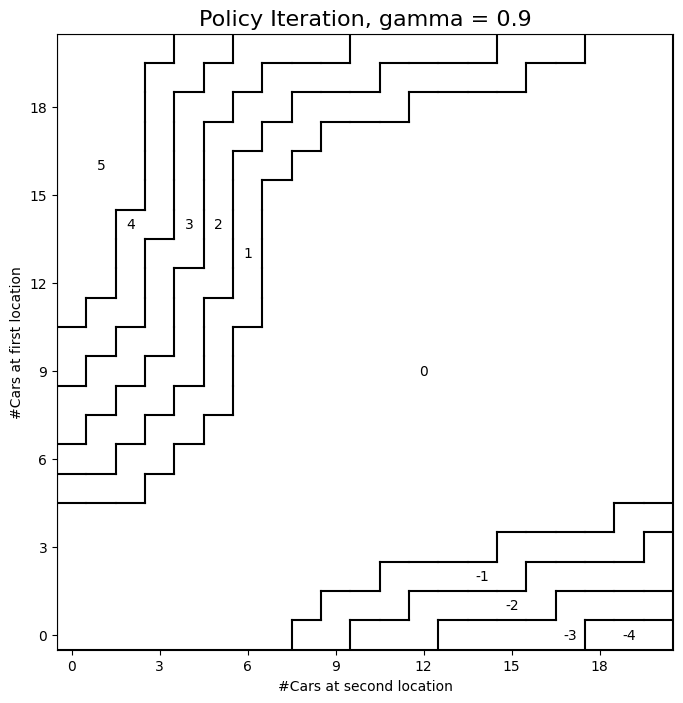

In [ ]:
display_optimal_policy_value_iteration(mdp)
display_optimal_policy_policy_iteration(mdp)

## Experiment with other values of gamma



---------- gamma = 0.5 ----------


Number of iterations until convergence: 14


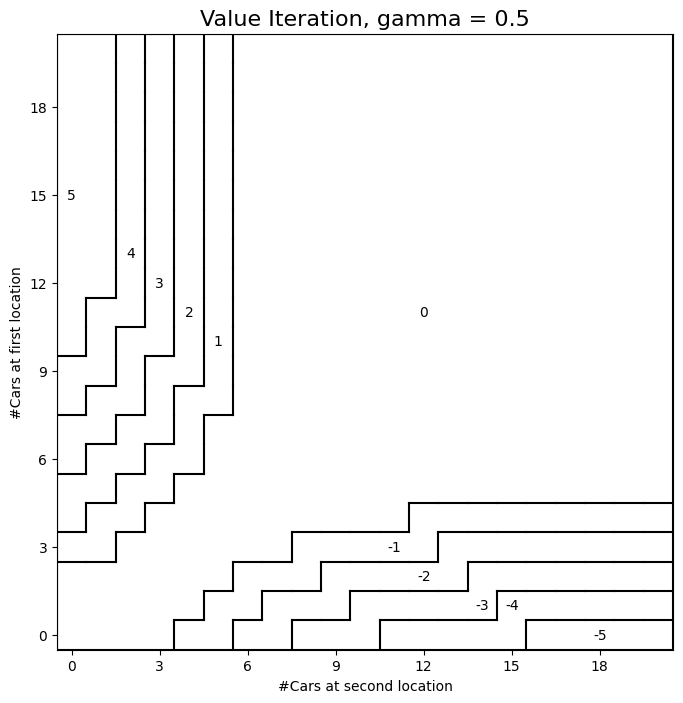

Number of iterations until convergence: 3


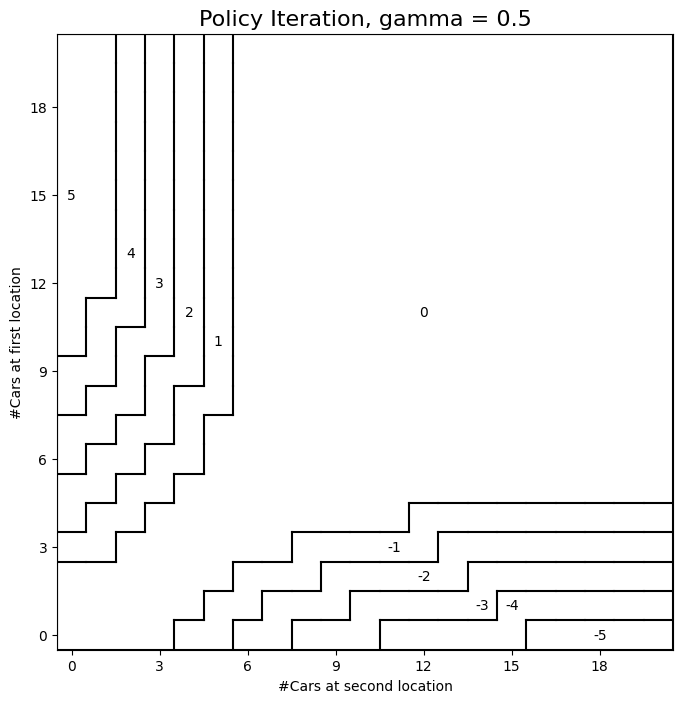



---------- gamma = 0.7 ----------


Number of iterations until convergence: 25


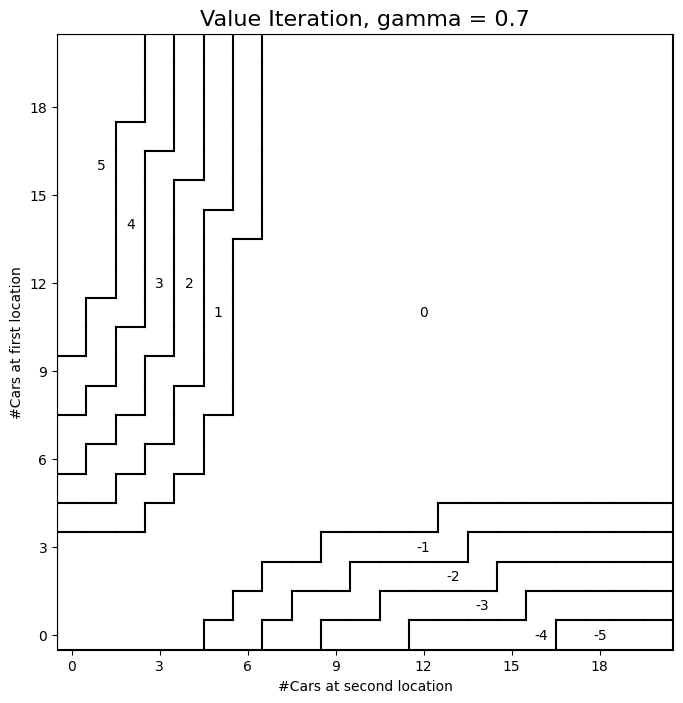

Number of iterations until convergence: 4


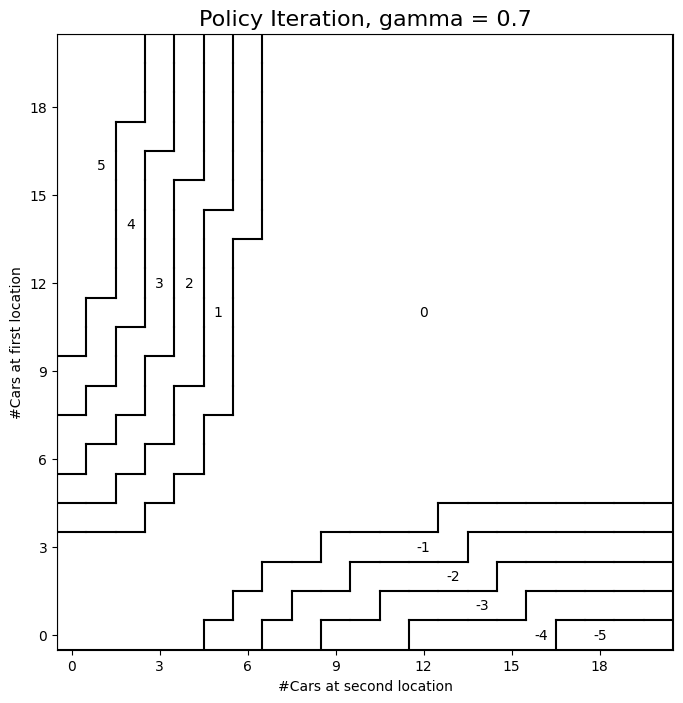



---------- gamma = 0.9 ----------


Number of iterations until convergence: 80


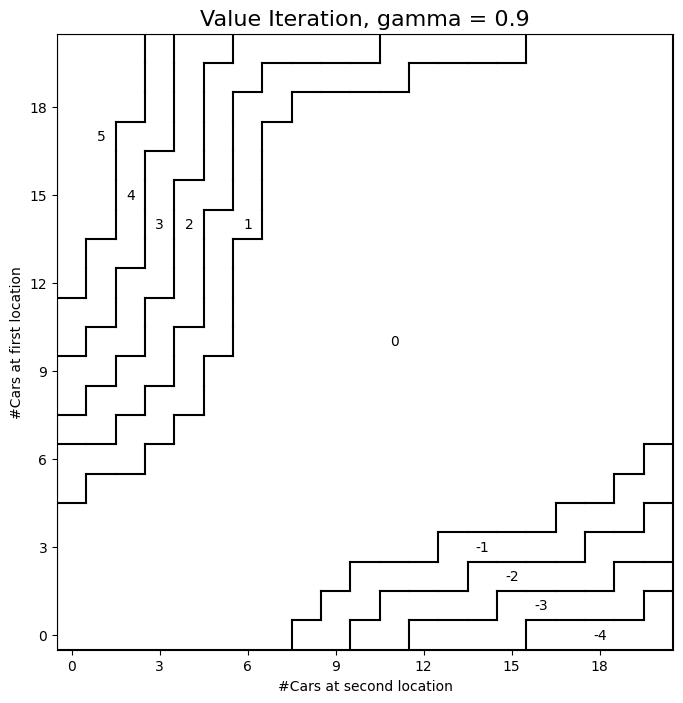

Number of iterations until convergence: 4


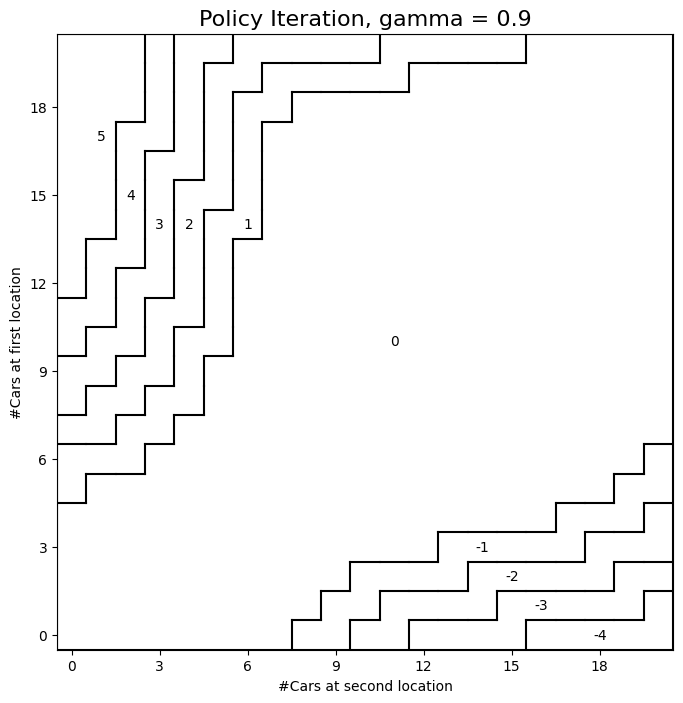



---------- gamma = 0.99 ----------


Number of iterations until convergence: 827


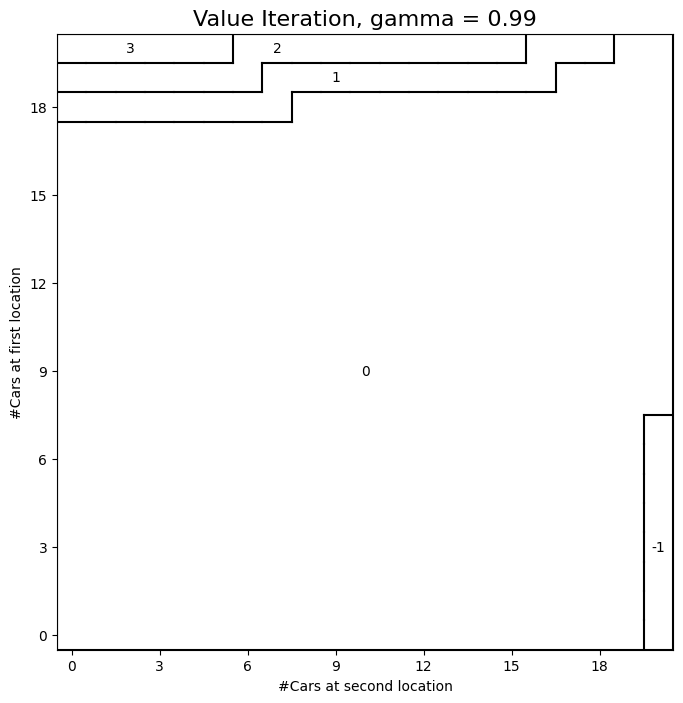

Number of iterations until convergence: 4


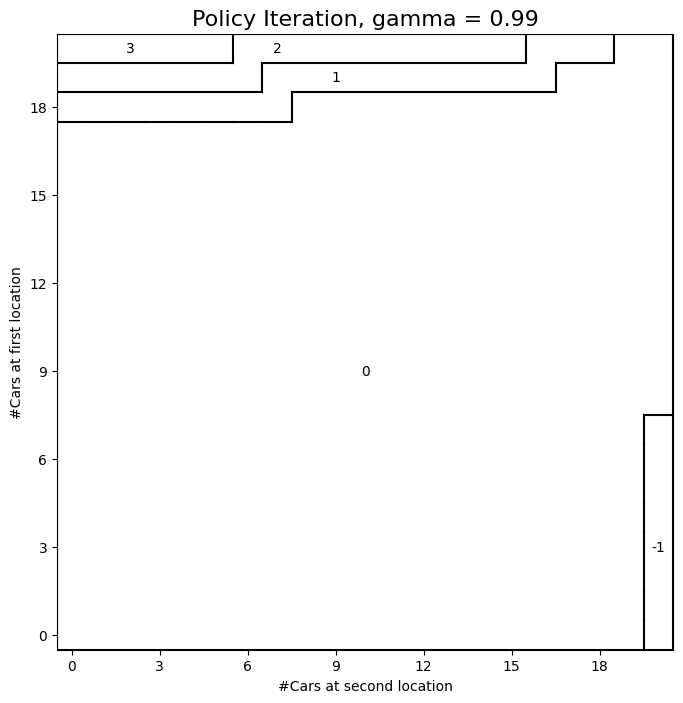

In [ ]:
gammas = [0.5, 0.7, 0.9, 0.99]

for gamma in gammas:
    print(f"\n\n---------- gamma = {gamma} ----------\n\n")
    mdp = MDP(
        action_range=(-5, 5),
        location_capacity=(20, 20),
        rental_params=(3, 4),
        return_params=(2, 2),
        gamma=gamma
    )
    display_optimal_policy_value_iteration(mdp)
    display_optimal_policy_policy_iteration(mdp)


## Experiment with different parameters

Number of iterations until convergence: 85


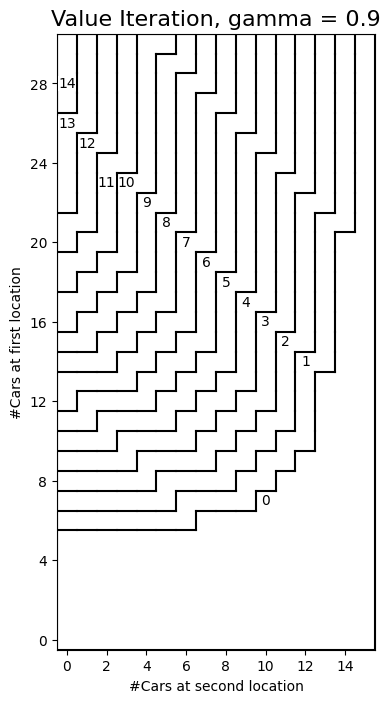

Number of iterations until convergence: 4


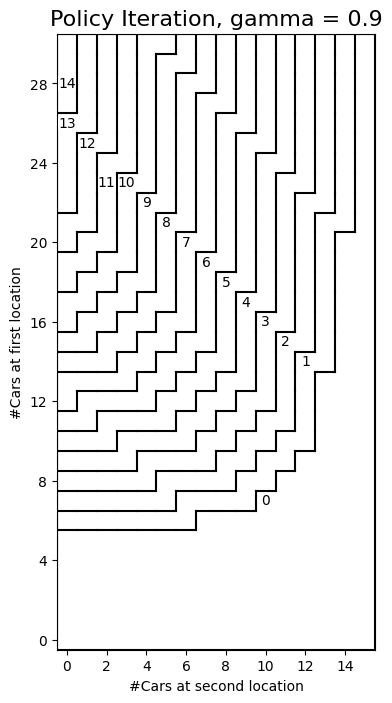

In [ ]:
mdp = MDP(
	action_range=(-8, 15),
	location_capacity=(30, 15),
	rental_params=(4, 10),
	return_params=(6, 1),
	gamma=0.90
)
display_optimal_policy_value_iteration(mdp)
display_optimal_policy_policy_iteration(mdp)

Number of iterations until convergence: 85


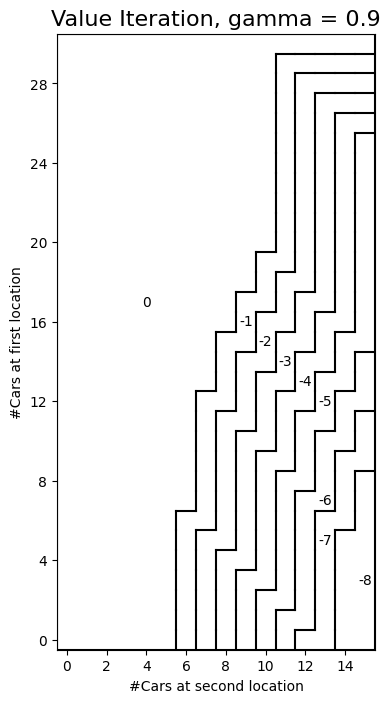

Number of iterations until convergence: 4


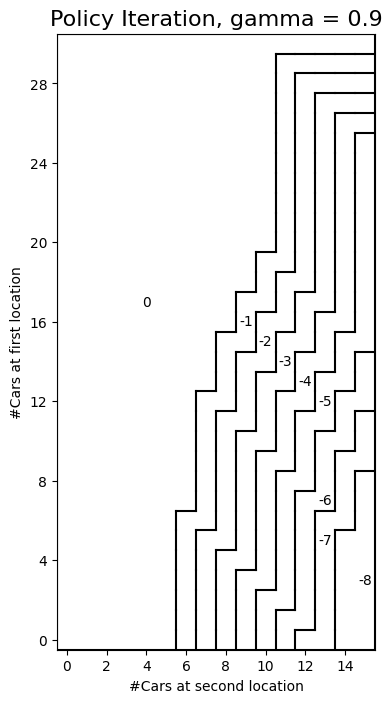

In [ ]:
mdp = MDP(
	action_range=(-8, 8),
	location_capacity=(30, 15),
	rental_params=(15, 4),
	return_params=(3, 4),
	gamma=0.90
)
display_optimal_policy_value_iteration(mdp)
display_optimal_policy_policy_iteration(mdp)